In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from test_helper import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec

import os 
import textwrap as tw
from PIL import Image

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/home/rajeev/Downloads/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rajeev/Downloads/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rajeev/Downloads/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rajeev/Downloads/env/lib/python3.6/site-packages/tensorflow/pyth

In [2]:
left_input_im = tf.placeholder(tf.float32, [None, 256, 128, 3], 'left_input_im')
right_input_im = tf.placeholder(tf.float32, [None, 256, 128, 3], 'right_input_im')
left_label = tf.placeholder(tf.float32, [None, ], 'left_label')
right_label = tf.placeholder(tf.float32, [None, ], 'right_label')

# print(np.shape(left_input_im), np.shape(right_input_im))
logits, model_left, model_right = inference(left_input_im, right_input_im)
global_step = tf.Variable(0, trainable=False)
global_init = tf.variables_initializer(tf.global_variables())



Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
(?, 256, 128, 3)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(?, 256, 128, 256)
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
(?, 128, 64, 256)
(?, 128, 64, 128)


(?, 64, 32, 128)
(?, 64, 32, 64)
(?, 32, 16, 64)
(?, 32, 16, 32)
(?, 16, 8, 32)
Instructions for updating:
Use keras.layers.flatten instead.
(?, 4096)
Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(?, 4096)
(?, 256, 128, 3)
(?, 256, 128, 256)
(?, 128, 64, 256)
(?, 128, 64, 128)


(?, 64, 32, 128)
(?, 64, 32, 64)
(?, 32, 16, 64)
(?, 32, 16, 32)
(?, 16, 8, 32)
(?, 4096)


(?, 4096)


INFO:tensorflow:Restoring parameters from MARS_model/model.ckpt


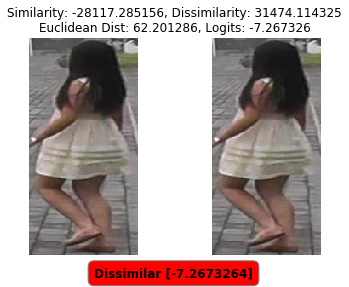

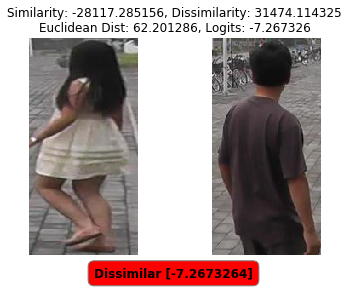

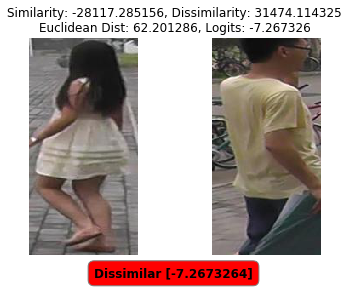

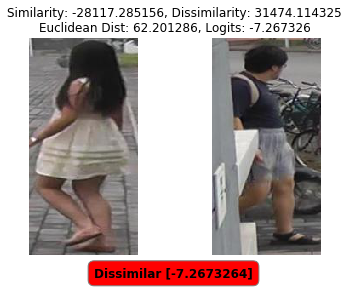

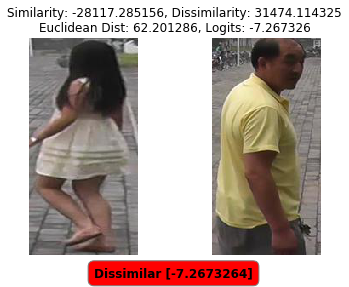

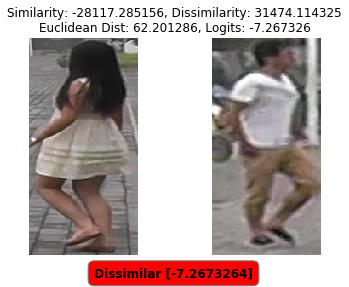

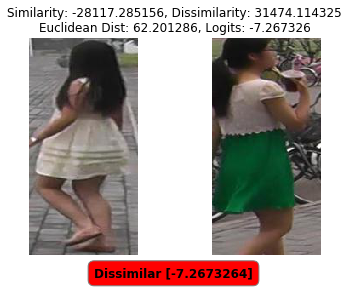

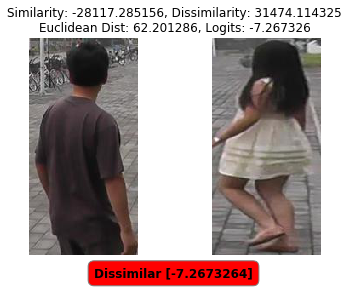

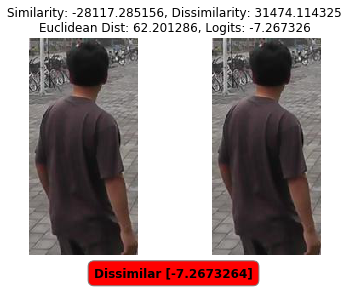

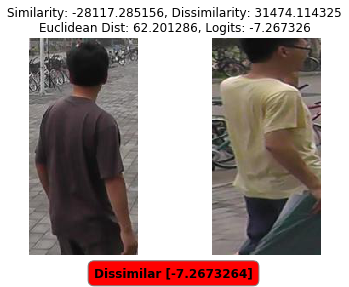

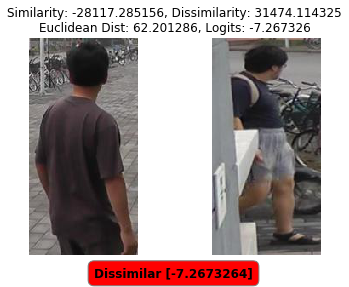

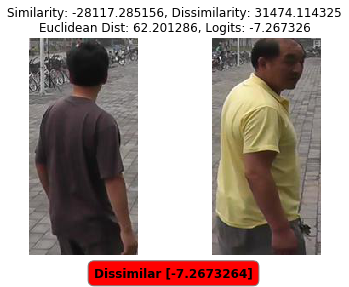

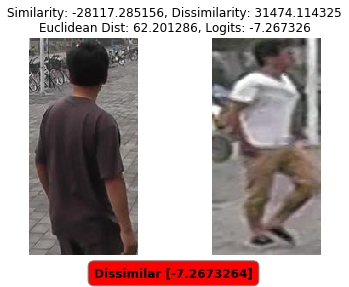

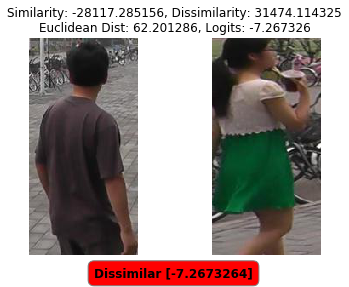

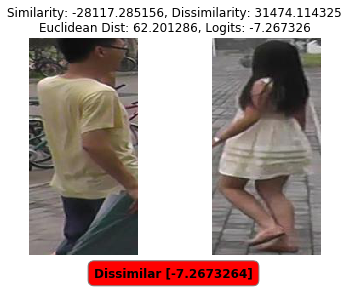

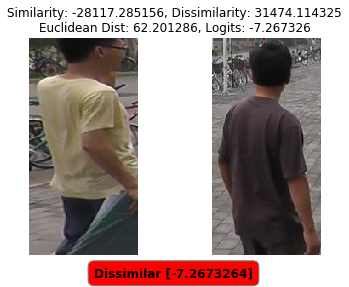

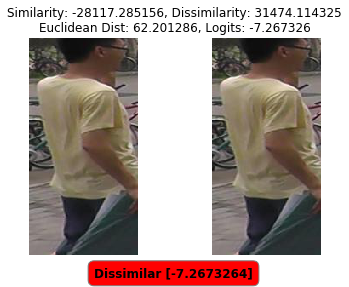

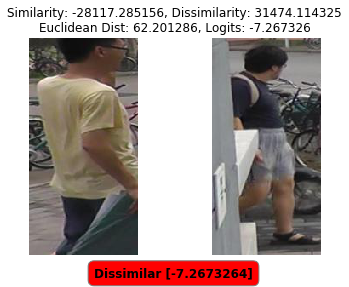

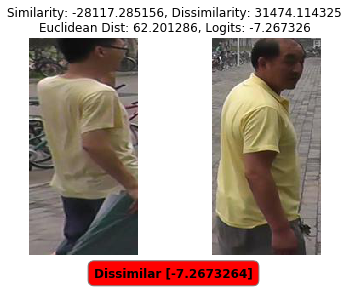

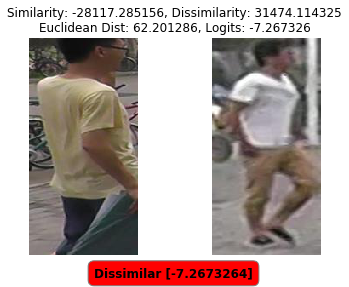

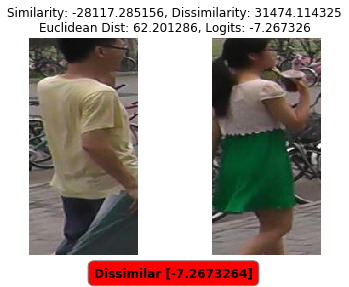

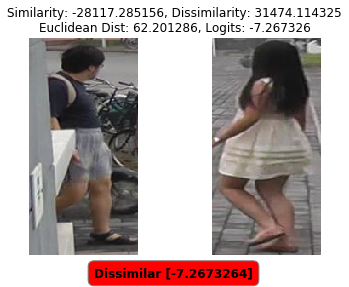

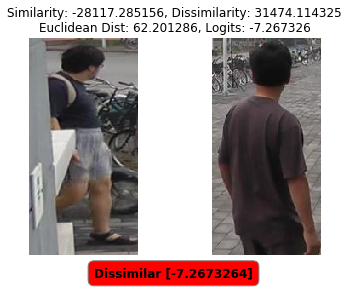

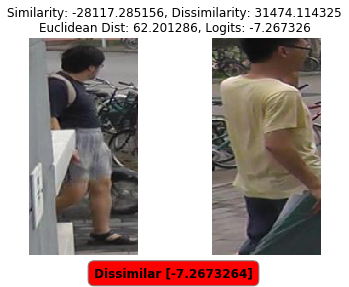

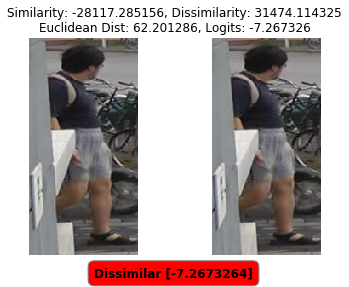

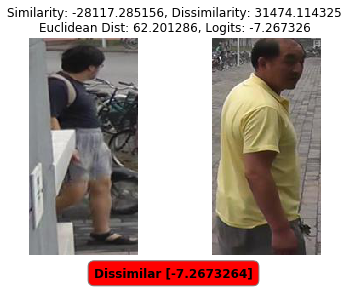

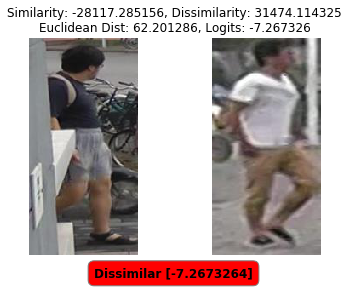

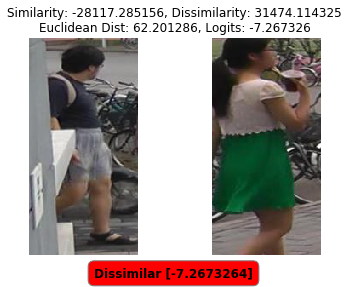

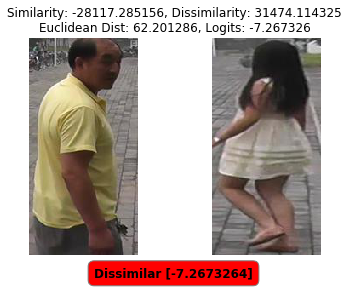

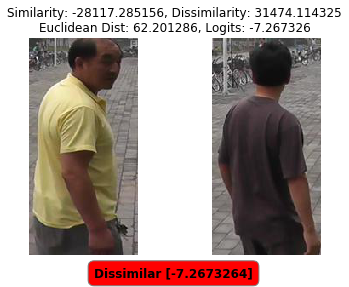

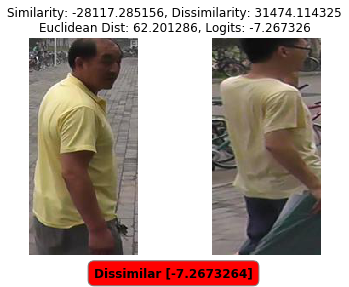

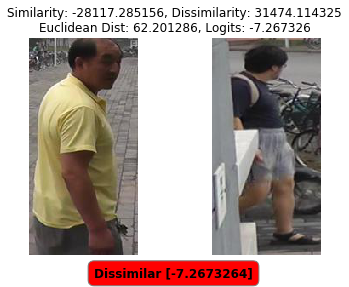

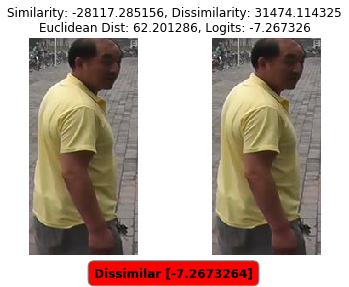

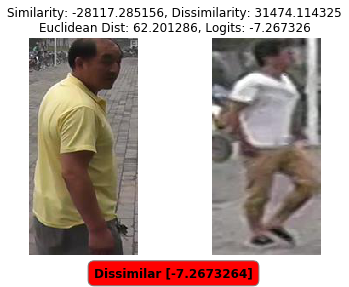

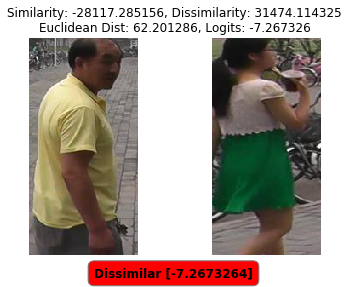

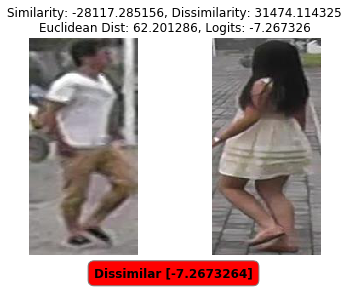

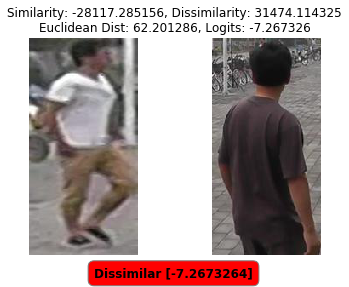

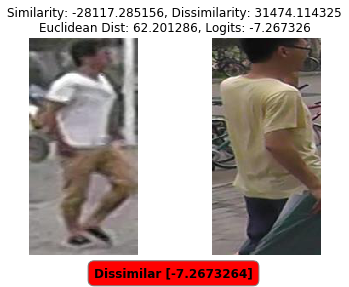

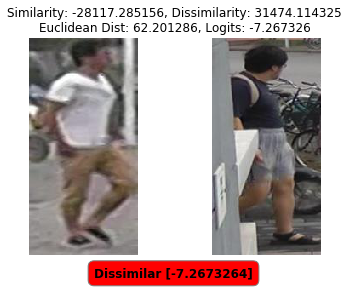

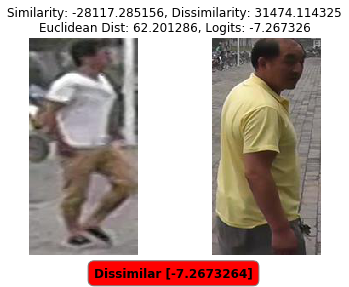

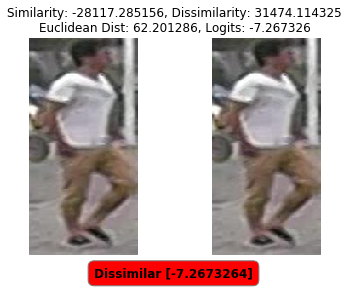

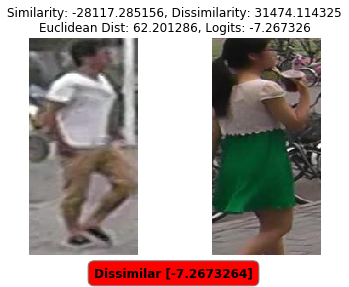

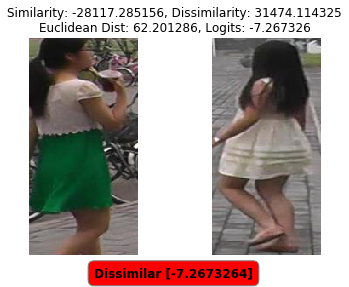

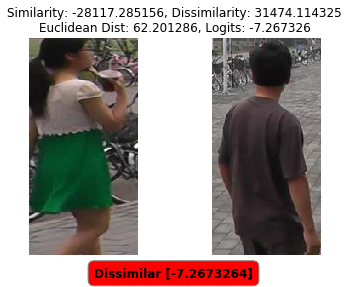

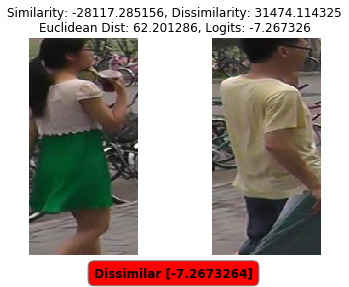

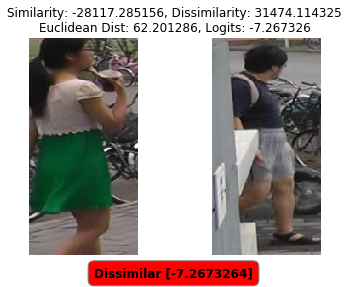

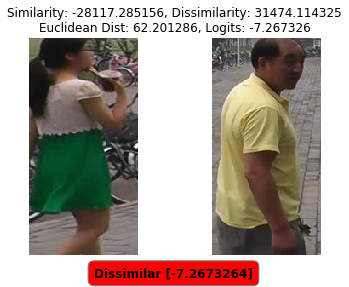

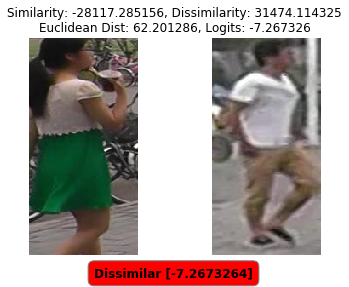

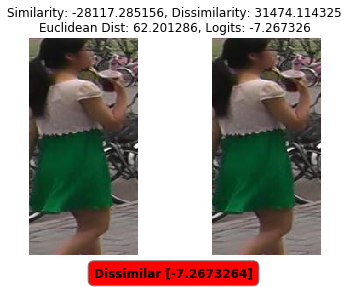

In [4]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(global_init)
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "MARS_model/model.ckpt")
    

    for im1 in range(1,8):
        for im2 in range(1,8):


            img = Image.open(str(im1) + '.jpg')
            img = np.array(img)[np.newaxis,:,:,:]
            # img2 = img
            img2 = Image.open(str(im2) + '.jpg')
            img2 = np.array(img2)[np.newaxis,:,:,:]


            my_logits, model_lf, model_rg = sess.run([logits, model_left, model_right], \
                                                     feed_dict={left_input_im:img, right_input_im:img2})
            
            lft = np.array(model_lf[0])
            rgt = np.array(model_rg[0])
            l = lft - rgt

            distance = np.sqrt(np.sum((l) ** 2))
            similarity = my_logits * np.square(distance)  # keep the similar label (1) close to each other
            dissimilarity = (1 - np.array(my_logits[0])) * np.square(np.max((0.5 - distance),
                                                           0))  # give penalty to dissimilar label if the distance is bigger than margin
            similarity_loss = np.mean(dissimilarity + similarity) / 2

            dist = cdist(model_lf, model_rg, 'cosine')
            euc = np.linalg.norm(model_lf - model_rg)

            fig = plt.figure()
            plt.title(('Similarity: %f, Dissimilarity: %f\nEuclidean Dist: %f, Logits: %f' % (similarity, dissimilarity, euc, my_logits)), loc='center')
            if my_logits > 0.0:
                textstr = 'Similar ' + str(my_logits)
                props = dict(boxstyle='round', facecolor='green', alpha=0.5)
                fig_txt = tw.fill(tw.dedent(textstr), width=80)
                plt.figtext(0.51, 0.05, fig_txt, horizontalalignment='center',
                            fontsize=12, multialignment='center',
                            bbox=dict(boxstyle="round", facecolor='green',
                                      ec="0.5", pad=0.5, alpha=1), fontweight='bold')
            else:
                textstr = 'Dissimilar ' + str(my_logits)
                props = dict(boxstyle='round', facecolor='red', alpha=0.5)
                fig_txt = tw.fill(tw.dedent(textstr), width=80)
                plt.figtext(0.51, 0.05, fig_txt, horizontalalignment='center',
                            fontsize=12, multialignment='center',
                            bbox=dict(boxstyle="round", facecolor='red',
                                      ec="0.5", pad=0.5, alpha=1), fontweight='bold')



            plt.axis('off')
            ax1 = fig.add_subplot(1, 2, 1)
            l_im = np.array(img)[0]
            ax1.imshow(l_im)
            ax1.axis('off')
            ax2 = fig.add_subplot(1, 2, 2)
            r_im = np.array(img2)[0]
            ax2.imshow(r_im)
            ax2.axis('off')


            plt.show()



